In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing 
import xgboost as xgb
from datetime import date
import pickle
import json
import gc
from tqdm import tqdm

# 1.3 Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor
from lightgbm.sklearn import LGBMRegressor as lgb

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.special import boxcox, inv_boxcox
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
from pandas_profiling import ProfileReport


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8")) #check the files available in the directory

C:\Users\tahahussein\Latest_Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


sample_submit.csv
test.csv
train.csv



# Data Reading

In [3]:
TRAINING_DF = pd.read_csv('input/train.csv')
TEST_DF = pd.read_csv('input/test.csv')
SUBMISSION_DF = pd.read_csv('input/sample_submit.csv')

In [4]:
TRAINING_DF.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.629,63.125,27109.234,0.646,8.241,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.053
1,990025,Camelopardalis B,0.818,81.005,30166.794,0.852,10.672,4.742,0.834,0.468,...,nan,nan,nan,nan,nan,19.178,nan,22.785,nan,0.060
2,990025,Virgo I,0.659,59.571,8441.707,0.500,8.840,5.584,0.469,0.364,...,nan,nan,nan,nan,nan,21.151,6.534,nan,nan,0.050
3,990025,UGC 8651 (DDO 181),0.556,52.333,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,5.912,nan,nan,0.049
4,990025,Tucana Dwarf,0.991,81.802,81033.957,1.131,13.801,13.189,0.910,0.918,...,nan,nan,nan,nan,nan,nan,5.612,nan,nan,0.154


In [5]:
TRAINING_DF["galaxy"] = TRAINING_DF["galaxy"].astype('category')
TRAINING_DF["galaxy"] = TRAINING_DF["galaxy"].cat.codes
TEST_DF["galaxy"] = TEST_DF["galaxy"].astype('category')
TEST_DF["galaxy"] = TEST_DF["galaxy"].cat.codes

In [6]:
TRAINING_DF.galaxy.nunique()

181

In [7]:
TEST_DF.galaxy.nunique()

172

In [8]:
# Target
vars_target = ['y']
# Unique identifier
vars_id = ['galaxy'] 

# Remove: 
    # ID, target
vars_to_remove = vars_target + vars_id   # Variables for model
vars_to_select = [x for x in TRAINING_DF.columns if x not in vars_to_remove]

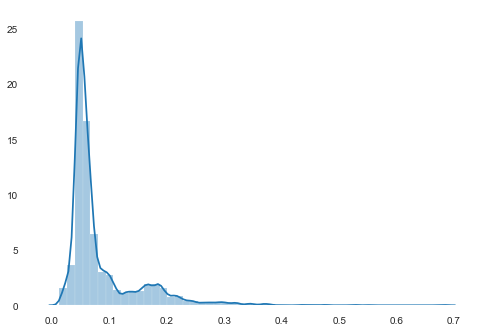

In [9]:
sns.distplot(TRAINING_DF[['y']])

In [10]:
len(TRAINING_DF.loc[TRAINING_DF.y < TRAINING_DF.y.quantile(.99)])

3826

In [11]:
# no_outliers_df = TRAINING_DF.loc[TRAINING_DF.y < TRAINING_DF.y.quantile(.99)].copy()

In [12]:
no_outliers_df = TRAINING_DF.copy()

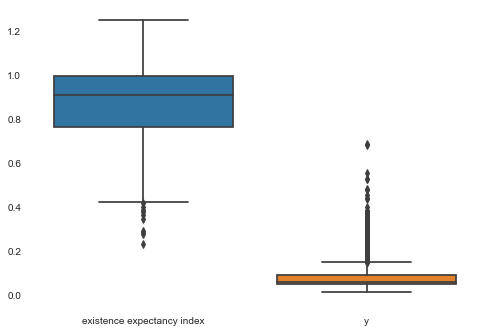

In [13]:
sns.boxplot(data = no_outliers_df[['existence expectancy index','y']])

In [14]:
no_outliers_df

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,96,0.629,63.125,27109.234,0.646,8.241,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.053
1,990025,33,0.818,81.005,30166.794,0.852,10.672,4.742,0.834,0.468,...,nan,nan,nan,nan,nan,19.178,nan,22.785,nan,0.060
2,990025,178,0.659,59.571,8441.707,0.500,8.840,5.584,0.469,0.364,...,nan,nan,nan,nan,nan,21.151,6.534,nan,nan,0.050
3,990025,163,0.556,52.333,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,5.912,nan,nan,0.049
4,990025,155,0.991,81.802,81033.957,1.131,13.801,13.189,0.910,0.918,...,nan,nan,nan,nan,nan,nan,5.612,nan,nan,0.154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,45,1.030,82.832,34310.471,0.855,18.579,10.557,0.907,0.863,...,0.943,0.902,1.061,124.564,143.908,26.439,3.024,29.295,0.581,0.042
3861,1015056,99,0.938,75.877,36899.068,0.929,16.154,9.152,0.866,0.748,...,0.915,0.798,1.055,163.665,184.291,20.638,4.471,31.085,0.518,0.037
3862,1015056,34,1.036,93.540,37002.978,1.085,21.066,16.661,0.984,1.101,...,1.097,1.045,1.115,66.499,112.887,28.155,5.194,32.146,0.364,0.166
3863,1015056,93,0.939,78.274,28180.460,0.688,9.389,8.909,0.736,0.603,...,0.596,0.755,0.826,182.249,175.409,38.963,2.854,27.227,0.712,0.024


In [15]:
# Split: train, test
msk = np.random.rand(len(no_outliers_df)) < 0.8

x_train_original = no_outliers_df[msk][vars_to_select]
x_test = no_outliers_df[~msk][vars_to_select]
y_train_original = no_outliers_df[msk][vars_target]
y_test = no_outliers_df[~msk][vars_target]



# Split train into train and validation
msk = np.random.rand(len(x_train_original)) < 0.8
x_train = x_train_original[msk][vars_to_select]
x_val = x_train_original[~msk][vars_to_select]
y_train = y_train_original[msk]
y_val = y_train_original[~msk]

In [16]:
# Transform train, test and validation tests into adecuate format for xgboost model

print('Creating xgb.DMatrix objects:')
print('  1. Creating xgb.DMatrix train')
dtrain = xgb.DMatrix(data = x_train.values, label = y_train.values, missing = np.nan, feature_names=x_train.columns)
print('  2. Creating xgb.DMatrix validation')
dval = xgb.DMatrix(data=x_val.values, label=y_val.values, missing=np.nan, feature_names=x_val.columns)
print('  3. Creating xgb.DMatrix test')
dtest = xgb.DMatrix(data=x_test.values, label=y_test.values, missing=np.nan, feature_names=x_test.columns)

Creating xgb.DMatrix objects:
  1. Creating xgb.DMatrix train
  2. Creating xgb.DMatrix validation
  3. Creating xgb.DMatrix test


In [17]:
# params = {'objective':'reg:squarederror', 
#           'eta':0.05,
#           'colsample_bytree': 0.8,
#           'subsample' : 0.7,
#           'learning_rate': 0.1,
#           'eval_metric': 'rmse',
#           'min_child_weight' : 1,
#           'max_depth': 5,
#           'gamma': 0.07,
#           'silent': 1,
#           'reg_alpha':0.005,
#           'scale_pos_weight': 1} # L2 regularization

In [18]:
params = {'eta': 0.05, 'colsample_bytree': 1, 'max_depth': 7,
            'subsample': 0.75,  'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 
            'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'min_child_weight': 1,}

In [19]:
evallist = [(dval, 'eval'), (dtrain, 'train'), (dtest, 'test')]

# Train model
print('Performance on each set measured by roc-auc (eval, train, test):')
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=7)

Performance on each set measured by roc-auc (eval, train, test):
[0]	eval-rmse:0.397887	train-rmse:0.401265	test-rmse:0.403372
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 7 rounds.
[1]	eval-rmse:0.378221	train-rmse:0.381404	test-rmse:0.383396
[2]	eval-rmse:0.359466	train-rmse:0.362551	test-rmse:0.364467
[3]	eval-rmse:0.341719	train-rmse:0.344632	test-rmse:0.34642
[4]	eval-rmse:0.324896	train-rmse:0.32762	test-rmse:0.32946
[5]	eval-rmse:0.308775	train-rmse:0.311428	test-rmse:0.313153
[6]	eval-rmse:0.293501	train-rmse:0.296031	test-rmse:0.297722
[7]	eval-rmse:0.27906	train-rmse:0.28145	test-rmse:0.283095
[8]	eval-rmse:0.265275	train-rmse:0.26755	test-rmse:0.26913
[9]	eval-rmse:0.252246	train-rmse:0.254375	test-rmse:0.255899
[10]	eval-rmse:0.23984	train-rmse:0.241842	test-rmse:0.243322
[11]	eval-rmse:0.228112	train-rmse:0.229951	test-rmse:0.231455
[12]	eval-rmse:0.216971	train-rmse:0.218656	test-rmse:0

In [20]:
# pd.DataFrame ( x_test , y_test , bst.predict(dtest) ) 
y_predict = pd.Series(bst.predict(dtest))

In [21]:
pd.concat ([y_test, y_predict], axis=1 )

,y,0
0,nan,0.049
1,nan,0.054
2,0.050,0.053
3,0.049,0.052
4,nan,0.086
...,...,...
3827,0.018,nan
3836,0.020,nan
3838,0.059,nan
3839,0.018,nan


In [22]:
# Sort variables by gain in model
variable_gain = bst.get_score(importance_type = 'gain')
variable_gain = pd.DataFrame(data = {'Variable': list(variable_gain.keys()), 
                                     'Gain': list(variable_gain.values())})

variable_gain.sort_values(by = 'Gain', ascending = False, inplace = True)
variable_gain.reset_index(drop = True, inplace = True)

variable_gain['Gain'] = variable_gain['Gain'].div(np.sum(variable_gain['Gain']))

# List of sorted variables by gain
top_variables = variable_gain['Variable']

In [23]:
variable_gain

,Variable,Gain
0,"Intergalactic Development Index (IDI), Rank",0.115
1,Intergalactic Development Index (IDI),0.090
2,Youth unemployment rate (female to male ratio),0.068
3,"Estimated gross galactic income per capita, fe...",0.047
4,"Mean years of education, female (galactic years)",0.042
...,...,...
73,Intergalactic inbound tourists (thousands),0.001
74,"Gross enrolment ratio, primary (% of primary u...",0.001
75,"Population, under age 5 (millions)",0.001
76,Jungle area (% of total land area),0.001


In [24]:
mae = metrics.mean_absolute_error(y_test, y_predict)
mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_predict)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.014094772845221381
MSE: 0.000679956996948642
RMSE: 0.02607598506190403
R-Squared: 0.8152797174596034


In [25]:
my_dtest = xgb.DMatrix(data=TEST_DF[vars_to_select].values,  missing=np.nan, feature_names=TEST_DF[vars_to_select].columns)

In [26]:
TEST_DF=TEST_DF.sort_values(by=['galaxy'])

In [27]:
TEST_DF.sort_index(inplace=True)

In [28]:
TEST_DF['predicted_y'] = pd.Series(bst.predict(my_dtest))

In [29]:
TEST_DF

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),predicted_y
0,1007012,78,0.456,51.563,12236.576,0.593,10.414,10.699,0.547,0.556,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.044
1,1007012,135,0.530,57.228,3431.884,0.675,7.239,5.311,0.498,0.410,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.043
2,1008016,135,0.561,59.380,27562.914,0.595,11.775,5.938,0.545,0.486,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.042
3,1007012,140,0.566,59.952,20352.233,0.838,11.614,10.068,0.692,0.523,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.044
4,1013042,169,0.588,55.428,23959.704,0.521,10.392,6.375,0.531,0.580,...,0.583,0.600,0.856,206.674,224.104,nan,7.688,nan,nan,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1016064,53,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.055
886,1016064,110,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.055
887,1016064,52,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.055
888,1016064,56,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.055


## Optimization part

- Ideally giving 100 to top 500 samples with highest p^2 values should optimize the likely increase.
- However, as the predictions can be faulty, this approach would result with lower Leaderboard Score.

E.g: If the original p^2 value is higher than the predicted p^2, it will increase the error as we are directly giving it 0.

- That's why, I believe its better to spread the risk for the samples in the bordering regions (400< [rank of p^2] <600).
- I assign 100 energy to top 400 samples and 50 energy to the remaining top 200 samples.

In [42]:
index = pd.Series(bst.predict(my_dtest))
pot_inc = -np.log(index+0.01)+3

In [43]:
p2= pot_inc**2

In [44]:
ss = pd.DataFrame({
    'Index':TEST_DF.index,
    'pred': TEST_DF['predicted_y'],
    'opt_pred':0,
    'eei':TEST_DF['existence expectancy index'], # So we can split into low and high EEI galaxies
})

In [45]:
ss.loc[p2.nlargest(400).index, 'opt_pred']=100
ss=ss.sort_values('pred')
ss.iloc[400:500].opt_pred = 50
ss.iloc[500:600].opt_pred = 40
ss.iloc[600:700].opt_pred = 10
ss=ss.sort_index()

In [46]:
increase = (ss['opt_pred']*p2)/1000

In [47]:
print(sum(increase), ss.loc[ss.eei < 0.7, 'opt_pred'].sum(), ss['opt_pred'].sum())

1803.9735703468339 6600 50000


In [48]:
ss.opt_pred.value_counts()

100    400
0      290
50     200
Name: opt_pred, dtype: int64

In [49]:
ss[['Index', 'pred', 'opt_pred']]

,Index,pred,opt_pred
0,0,0.041,100
1,1,0.041,100
2,2,0.041,100
3,3,0.042,100
4,4,0.026,100
...,...,...,...
885,885,0.071,50
886,886,0.071,50
887,887,0.071,50
888,888,0.071,50


In [50]:
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)

## Second Approach

In [33]:
ss = pd.DataFrame({
    'Index':TEST_DF.index,
    'pred': TEST_DF['predicted_y'],
    'opt_pred':0,
    'eei':TEST_DF['existence expectancy index'], # So we can split into low and high EEI galaxies
})

In [34]:
n = 340
#Giving the max of Energy to the 340 first element (ordered using the likely Increasing Index)
ss.opt_pred[:n]=100
ss.opt_pred[n:] = 0
c=100
alpha = 0.62685
for i in range(n,374):
    if c>=alpha: 
        c=c-alpha
        ss.loc[i,'opt_pred'] =c
alpha=0.067345
for i in range(374,455):
    if c>=alpha: 
        c=c-alpha
        ss.loc[i,'opt_pred'] =c
    else:
        ss.loc[i,'opt_pred'] = 0
alpha = 0.03
for i in range(455,465):
    if c>=alpha: 
        c=c-alpha
        ss.loc[i,'opt_pred'] =c
alpha=0.4339465
for i in range(465,890):
    if c>=alpha: 
        c=c-alpha
        ss.loc[i,'opt_pred'] =c
    else:
        ss.loc[i,'opt_pred'] = 0

In [35]:

#Checking if the sum of opt_pred in rows having eei<0.7 is >5000
print("sum",ss.opt_pred.sum())
print("left", (50000-ss.opt_pred.sum())) 
print("eei Sum",ss[ss.eei<0.7]['opt_pred'].sum())

sum 49999.995680999906
left 0.004319000094255898
eei Sum 6600.0


In [36]:
ss[['Index', 'pred', 'opt_pred']].to_csv('sub.csv', index=False)